# Проектная работа по курсу NLP от OTUS

### на тему "Оценка разнообразия и достоверности рерайтинга математических задач для школьников для различных техник prompt engineering"

#### План работы:
Для различных техник prompt engineering оценить:

а) разнообразие - частотность выбора тех или иных вариантов из списка, замена мест дествия и самих действий

б) достоверность - соответствие параметрам рального мира 

в) понимание llm своей задачи - отсутствие замены исходных чисел, попытки предпринять решение задачи или выдумать что-то совершенно новое

#### Данные собраны заранее с помощью GigaChat
Исходные данные это процедурно сгенерированные задачи про транспортные средства на тему "скорость, время, расстояние"

Задачей llm ставилось поменять текст задачи так, чтобы фигурировали не транспортные средства, а те или иные живые объекты из списка

##### Заимпортим нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

##### Загрузим данные

In [2]:
df_zero_shot = pd.read_csv('zero_shot.csv')
df_few_shot = pd.read_csv('few_shot.csv')
df_imp_system = pd.read_csv('system+imp_word.csv')
df_one_shot_system = pd.read_csv('system+one_shot+imagine.csv')
df_system = pd.read_csv('system+imagine.csv')
df_system_ins = pd.read_csv('system+imagine(ins).csv')

dfs = {'zero_shot':df_zero_shot,
       'few_shot':df_few_shot,
       'system+imp_word':df_imp_system,
       'system+one_shot+imagine':df_one_shot_system,
       'system+imagine':df_system,
       'system+imagine(ins)':df_system_ins}

In [3]:
df_zero_shot.columns

Index(['task_text', 'answer_num', 'gigachat_completion'], dtype='object')

Подготовим списки, которые использовались при генерации промтов

In [4]:
ani1 = 'бабочк, кузнеч, жук, стрекоз, гусениц, улитк, пчел, шмел, клоп, мурав'
loc1 = 'лес, опушк, болот, гор, пещер, пол, полян, дерев, куст, цвет'

ani2 = 'лошад, волк, зай, зая, рыс, тиг, лев, льв, косул, олен, лос'
loc2 = 'лес, пол, болот, гор'

# с лисой только с корнем будут ошибки в анализе
ani_fox = ', лиса, лису, лисе, лисы'
ani2 = ani2+ani_fox

##### Анализ разнообразия

Частотность выбора тех или иных вариантов из списка, замена мест дествия и самих действий

In [5]:
def is_in_ani_list(row):
    words = row.replace(',',' ').replace('.',' ')
    words = re.sub("\s\s+", " ", words)
    words = words.split(' ')
    words = [w.lower() for w in words]
    for a2 in ani2.split(', '):
        for w in words:
            if a2 in w:
                return a2
    return 'Не из списка'

In [6]:
sers = []
for k, df in dfs.items():
    
    # потому что тут подставлялись списки, а не отдельно
    if k in ['zero_shot', 'few_shot']:
        
        ser = df['gigachat_completion'].apply(is_in_ani_list)
        sers.append(ser)
        
sers = pd.concat(sers)
sers.value_counts()

зай             49
Не из списка    30
олен            12
лошад            7
волк             2
Name: gigachat_completion, dtype: int64

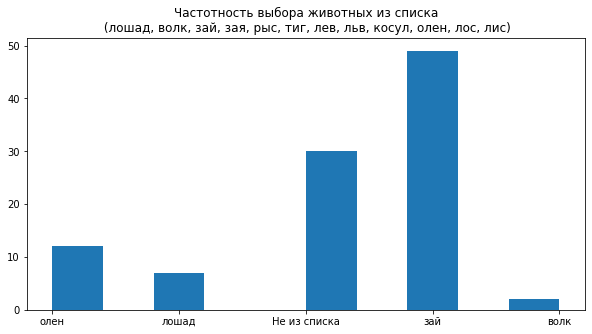

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(sers.values)
ax.set_title('Частотность выбора животных из списка\n ({})'.format(ani2[:-19]))
plt.show()

**Вывод**: с разнообразием объектов справляется не очень хорошо

In [8]:
def is_in_loc_list(row):
    words = row.replace(',',' ').replace('.',' ')
    words = re.sub("\s\s+", " ", words)
    words = words.split(' ')
    words = [w.lower() for w in words]
    for lc2 in loc2.split(', '):
        for w in words:
            if lc2 in w:
                return lc2
    return 'Не из списка'

In [9]:
sers = []
for k, df in dfs.items():
    
    # потому что тут подставлялись списки, а не отдельно
    if k in ['zero_shot', 'few_shot']:
        
        ser = df['gigachat_completion'].apply(is_in_loc_list)
        sers.append(ser)
        
sers = pd.concat(sers)
sers.value_counts()

лес             65
пол             14
гор             11
Не из списка    10
Name: gigachat_completion, dtype: int64

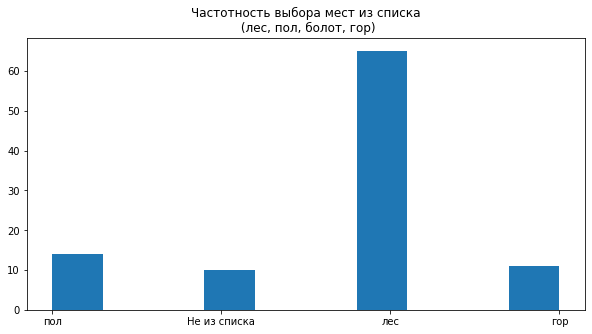

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(sers.values)
ax.set_title('Частотность выбора мест из списка\n ({})'.format(loc2))
plt.show()

**Вывод**: с разнообразием мест справляется не очень хорошо

In [11]:
def is_in_act_list(row):
    words = row.replace(',',' ').replace('.',' ')
    words = re.sub("\s\s+", " ", words)
    words = words.split(' ')
    words = [w.lower() for w in words]
    for act in ['шел', 'ехал', 'едет', 'бежал','вышл', 'вылет', 'выпрыг', 'двигал']:
        for w in words:
            if act in w:
                return act
    return 'Не из списка'

In [12]:
sers = []
for k, df in dfs.items():
    
    ser = df['gigachat_completion'].apply(is_in_act_list)
    sers.append(ser)
        
sers = pd.concat(sers)
sers.value_counts()

ехал            171
бежал            52
вылет            42
Не из списка     12
двигал           10
выпрыг            5
шел               4
вышл              3
едет              1
Name: gigachat_completion, dtype: int64

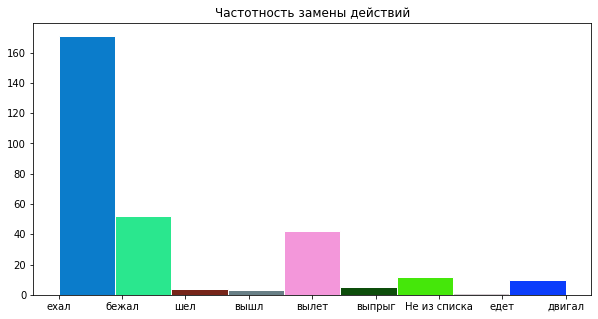

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
colors = [(np.random.randint(255)/255,
          np.random.randint(255)/255,
          np.random.randint(255)/255) for _ in range(len(sers.value_counts().to_dict()))]
N, bins, patches = ax.hist(sers.values, bins = len(sers.value_counts().to_dict()), edgecolor='white')

for i in range(len(sers.value_counts().to_dict())):
    patches[i].set_facecolor(colors[i])

ax.set_title('Частотность замены действий')
plt.show()

**Вывод**: с разнообразием в целом при подаче списка возможных вариантов есть сильно более частотные варианты выбора и такие, которые не встречаются никогда; можно говорить, что с разнообразием llm справляется довольно плохо.

##### Анализ достоверности

Соответствие параметрам рального мира

In [14]:
def is_correct_action_for_animal(row):
    words = row.replace(',',' ').replace('.',' ')
    words = re.sub("\s\s+", " ", words)
    words = words.split(' ')
    words = [w.lower() for w in words]
    
    obj_animal = False
                
    for a1 in ani1.split(', '):
        for w in words:
            if a1 in w:
                obj_animal = True
    for a2 in ani2.split(', ')+['животн']:
        for w in words:
            if a2 in w:
                obj_animal = True
                
    if obj_animal:           
        act = 'ехал'
        for w in words:
            if act in w:
                return 'Некорректно'
        return 'Корректно'
    else:
        for act in ['ехал', 'двигал']:
            for w in words:
                if act in w:
                    return 'Корректно'
        return 'Некорректно'

In [15]:
sers = []
for k, df in dfs.items():
    
    ser = df['gigachat_completion'].apply(is_correct_action_for_animal)
    sers.append(ser)
        
sers = pd.concat(sers)
sers.value_counts()

Корректно      170
Некорректно    130
Name: gigachat_completion, dtype: int64

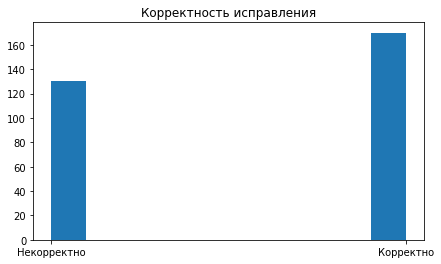

In [16]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(sers.values)
ax.set_title('Корректность исправления')
plt.show()

Посмотрим в разрезе техник prompt engineering

In [17]:
promt_tech = {'zero_shot':'zero_shot',
       'few_shot':'few_shot',
       'system+imp_word':'detailed+few_shot+important',
       'system+one_shot+imagine':'detailed+one_shot',
       'system+imagine':'detailed(ani)',
       'system+imagine(ins)':'detailed(ins)'}

In [18]:
sers = {'is_correct':[], 'prompt':[]}
for k, df in dfs.items():
    
    ser = df['gigachat_completion'].apply(is_correct_action_for_animal)
    sers['is_correct'] = sers['is_correct'] + list(ser.values)
    sers['prompt'] = sers['prompt'] + [promt_tech[k] for _ in range(len(df))]

In [19]:
stats = pd.DataFrame(sers)

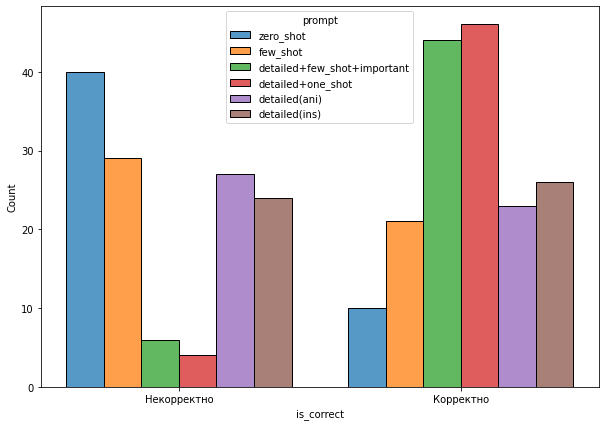

In [20]:
fig,ax = plt.subplots(figsize=(10,7))
sns.histplot(data=stats, x ='is_correct', hue='prompt', multiple="dodge", shrink=.8)
plt.show()

##### Анализ понимания llm своей задачи

In [21]:
def is_same_numbers(row):
    task_in = row['task_text']
    task_out = row['gigachat_completion']
    
    nums_in = re.findall(r'\d+', task_in)
    nums_out = re.findall(r'\d+', task_out)
    
    if nums_in == nums_out:
        return 'Совпало'
    else:
#         print(task_in)
#         print('\n----------------------------------------------------------------------------')
#         print(task_out)
#         print('\n============================================================================')
        return 'Не совпало'

In [22]:
sers = []
for k, df in dfs.items():
    
    ser = df.apply(is_same_numbers, axis=1)
    sers.append(ser)
        
sers = pd.concat(sers)
sers.value_counts()

Совпало       249
Не совпало     51
dtype: int64

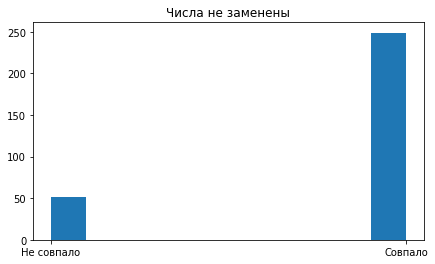

In [23]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist(sers.values)
ax.set_title('Числа не заменены')
plt.show()

Теперь посмотрим в разрезе различных техник промпт-инжиниринга

In [24]:
sers = {'is_correct':[], 'prompt':[]}
for k, df in dfs.items():
    
    ser = df.apply(is_same_numbers, axis=1)
    sers['is_correct'] = sers['is_correct'] + list(ser.values)
    sers['prompt'] = sers['prompt'] + [promt_tech[k] for _ in range(len(df))]

In [25]:
stats = pd.DataFrame(sers)

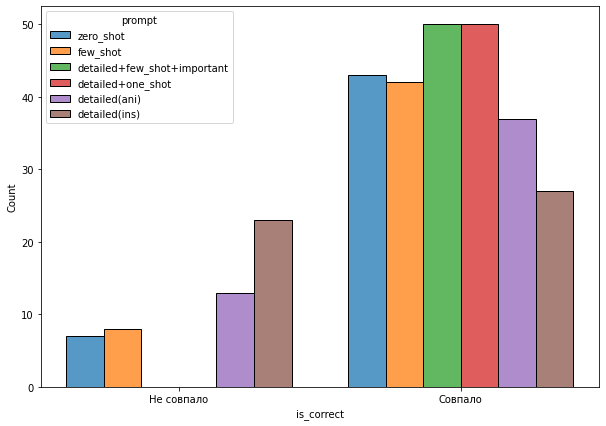

In [26]:
fig,ax = plt.subplots(figsize=(10,7))
sns.histplot(data=stats, x ='is_correct', hue='prompt', multiple="dodge", shrink=.8)
plt.show()

### Отдельная тема - решение задачи :)

Zero shot

In [27]:
df = pd.read_csv('math_solving.csv')

In [28]:
def compare_answ(row):
    gt = row['answer_num']
    pred = row['gigachat_completion']
    try:
        gt = int(gt)
        pred = int(pred)
        return gt == pred
    except Exception as e:
        print(e)
        return False

In [29]:
ser = df.apply(lambda x: compare_answ(x), axis=1)

invalid literal for int() with base 10: '10 км'
invalid literal for int() with base 10: '44 км/ч'
invalid literal for int() with base 10: '30 км/ч'
invalid literal for int() with base 10: '30 км/ч'
invalid literal for int() with base 10: '56 км/ч'
invalid literal for int() with base 10: '64 км/ч'


In [30]:
ser.value_counts()

False    195
True       5
dtype: int64

Chain of thoughts

In [31]:
df = pd.read_csv('math_solving_chain_o_thoughts.csv')

In [32]:
def compare_answ(row):
    gt = row['answer_num']
    pred = row['pred_answ']
    try:
        gt = int(gt)
        pred = int(pred)
        return gt == pred
    except Exception as e:
        print(e)
        return False

In [33]:
df['correct'] = df.apply(lambda x: compare_answ(x), axis=1)

cannot convert float NaN to integer
cannot convert float NaN to integer
cannot convert float NaN to integer


In [34]:
df['correct'].value_counts()

True     104
False     96
Name: correct, dtype: int64

В промпте были примеры задач типа 4 и 2, нужно было найти расстояние

In [35]:
df.groupby('task_type')['correct'].value_counts()

task_type  correct
1          False      41
           True       14
2          False      25
           True       21
3          False      26
           True       14
4          True       55
           False       4
Name: correct, dtype: int64

In [36]:
# исправление небольшого косяка в данных
df['unknown'] = df.apply(lambda x: 'distance' if x['task_type'] == 4 else x['unknown'], axis=1)

In [37]:
df.groupby('unknown')['correct'].value_counts()

unknown      correct
distance     True       81
             False      29
first_speed  False      38
             True        4
time         False      29
             True       19
Name: correct, dtype: int64

In [38]:
29/81, 38/4, 19/29

(0.35802469135802467, 9.5, 0.6551724137931034)

**Выводы:** можно предположить зависимость качества решения задачи от наличия примера такого типа задачи в промпте